In [ ]:
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from google.colab import files

# dataset 만들기

In [ ]:
files.upload()

Saving flower_photos.zip to flower_photos.zip


In [ ]:
!unzip flower_photos.zip

Archive:  flower_photos.zip
replace __MACOSX/._flower_photos? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
ls

flower_photos/  flower_photos.zip  __MACOSX/  sample_data/


In [ ]:
batch_size = 32
img_width = 224
img_height = 224

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='flower_photos',
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='flower_photos',
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names

In [ ]:
for img, label in train_ds:
    print(img.shape,label.shape)
    break

(32, 224, 224, 3) (32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# modeling

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3), pooling=None,
    classifier_activation='softmax'
)

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.layers import Dense, Flatten

model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(5, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5005      
Total params: 121,581,237
Trainable params: 106,866,549
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
init_epochs=5

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=init_epochs
)

Epoch 1/5
92/92 [==============================] - 36s 328ms/step - loss: 16.9533 - accuracy: 0.6941 - val_loss: 0.8255 - val_accuracy: 0.7847
Epoch 2/5
92/92 [==============================] - 30s 323ms/step - loss: 0.2414 - accuracy: 0.9424 - val_loss: 0.9729 - val_accuracy: 0.8106
Epoch 3/5
92/92 [==============================] - 30s 323ms/step - loss: 0.2496 - accuracy: 0.9755 - val_loss: 1.9425 - val_accuracy: 0.7643
Epoch 4/5
92/92 [==============================] - 30s 324ms/step - loss: 0.1669 - accuracy: 0.9741 - val_loss: 1.3550 - val_accuracy: 0.8011
Epoch 5/5
92/92 [==============================] - 30s 323ms/step - loss: 0.0279 - accuracy: 0.9932 - val_loss: 1.4499 - val_accuracy: 0.8338


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [ ]:
# 해당 층 이후부터 미세 조정
fine_tune_at = 12 

# `fine_tune_at` 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
fine_tune_epochs = 5
total_epochs =  init_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/10
92/92 [==============================] - 30s 323ms/step - loss: 0.0175 - accuracy: 0.9983 - val_loss: 1.1271 - val_accuracy: 0.8474
Epoch 6/10
92/92 [==============================] - 30s 325ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 1.1405 - val_accuracy: 0.8433
Epoch 7/10
92/92 [==============================] - 30s 325ms/step - loss: 1.5788e-04 - accuracy: 1.0000 - val_loss: 1.1325 - val_accuracy: 0.8420
Epoch 8/10
92/92 [==============================] - 30s 325ms/step - loss: 8.8627e-05 - accuracy: 1.0000 - val_loss: 1.1436 - val_accuracy: 0.8379
Epoch 9/10
92/92 [==============================] - 30s 324ms/step - loss: 6.9261e-05 - accuracy: 1.0000 - val_loss: 1.1613 - val_accuracy: 0.8379
Epoch 10/10
92/92 [==============================] - 30s 323ms/step - loss: 5.5802e-05 - accuracy: 1.0000 - val_loss: 1.1848 - val_accuracy: 0.8338


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

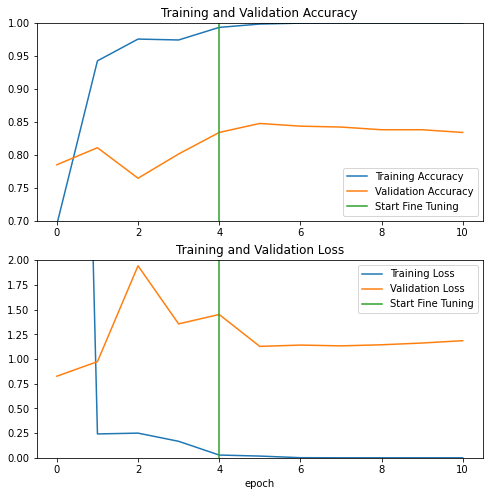

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([init_epochs-1,init_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([init_epochs-1,init_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 40.46 percent confidence.


In [ ]:
model.save('vgg16.h5')

In [ ]:
files.download('vgg16.h5')